In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

In [2]:
phenotype_file = 'C:\\Users\\user\\Documents\\Take home excercise(Gene Causality)\\scrambled.opentargets_step2.for_llm.tsv'
ground_truth_file = 'C:\\Users\\user\\Documents\\Take home excercise(Gene Causality)\\opentargets_step2.labels'

In [3]:
phenotypes = pd.read_csv(phenotype_file, sep='\t')
ground_truth = pd.read_csv(ground_truth_file)
gene_embeddings = pd.read_csv('gene_embeddings.csv')
phenotype_embeddings = pd.read_csv('phenotype_embeddings.csv')

# Create a unique subset

In [4]:
import hashlib

In [5]:
name = 'RABIALI'
hashed_name = hashlib.sha256(name.encode('utf-8')).hexdigest()

# Set the seed using the hash
seed = int(hashed_name, 16) % (2**32)
np.random.seed(seed)

# Randomly sample 500 phenotypes
sampled_phenotypes = phenotypes.sample(n=500, random_state=seed)
print(f"Sampled {len(sampled_phenotypes)} phenotypes for analysis")

Sampled 500 phenotypes for analysis


# Data preparation

In [13]:
# Merge phenotype and gene embeddings with the ground truth data

phenotype_embeddings['Unnamed: 0'] = sampled_phenotypes['row_number']
gene_embeddings['Unnamed: 0'] = sampled_phenotypes['row_number']

# Label dataset as causal or non-causal
causal_genes = set(ground_truth['symbol\t"gene"'])

sampled_phenotypes['label'] = sampled_phenotypes['row_number'].apply(lambda x: 'causal' if x in causal_genes else 'non-causal')



# Merge embeddings into a single dataset
merged_data = pd.merge(phenotype_embeddings, gene_embeddings, on='Unnamed: 0', how='inner')
merged_data = pd.merge(merged_data, sampled_phenotypes[['row_number', 'label']], left_on='Unnamed: 0', right_on= 'row_number', how='inner')

print("dataset created for analysis")
print(merged_data.head())

dataset created for analysis
   Unnamed: 0                                                0_x  \
0         1.0  Carotenoid and tocopherol levels (beta-caroten...   
1         3.0  Sphingolipid levels (SM 14:0Mol%) (sphingomyel...   
2         5.0     Vitamin D insufficiency (25-Hydroxyvitamin D2)   
3         7.0                      Magnesium levels (Magneseium)   
4         8.0                                   Magnesium levels   

                                   gpt_description_x  \
0  Carotenoids and tocopherols are important clas...   
1  Sphingolipids are a class of lipids that play ...   
2  Vitamin D insufficiency, specifically referrin...   
3  Magnesium is an essential mineral that plays a...   
4  Magnesium is an essential mineral that plays a...   

                                         embedding_x              0_y  \
0  [0.03543854132294655, -0.002083840314298868, -...            ATMIN   
1  [-0.003154945094138384, -0.016002262011170387,...         C16orf46   
2  [0.

# Dimensionality reduction (PCA)

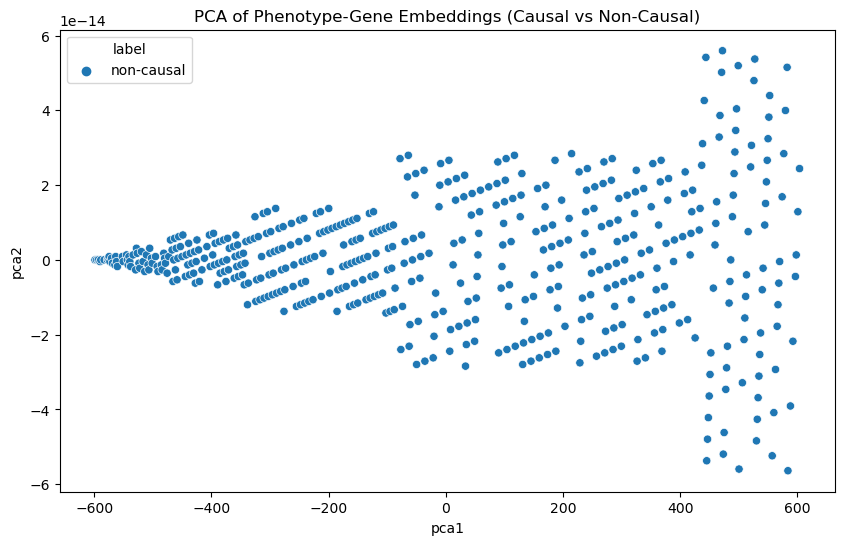

In [16]:
from sklearn.decomposition import PCA

# Select only numeric columns for PCA
numeric_data = merged_data.select_dtypes(include=[float, int])

# Perform PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(numeric_data)

merged_data['pca1'] = pca_transformed[:, 0]
merged_data['pca2'] = pca_transformed[:, 1]


# Visualize the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='pca1', y='pca2', hue='label')
plt.title('PCA of Phenotype-Gene Embeddings (Causal vs Non-Causal)')
plt.show()


# Clustering analysis

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


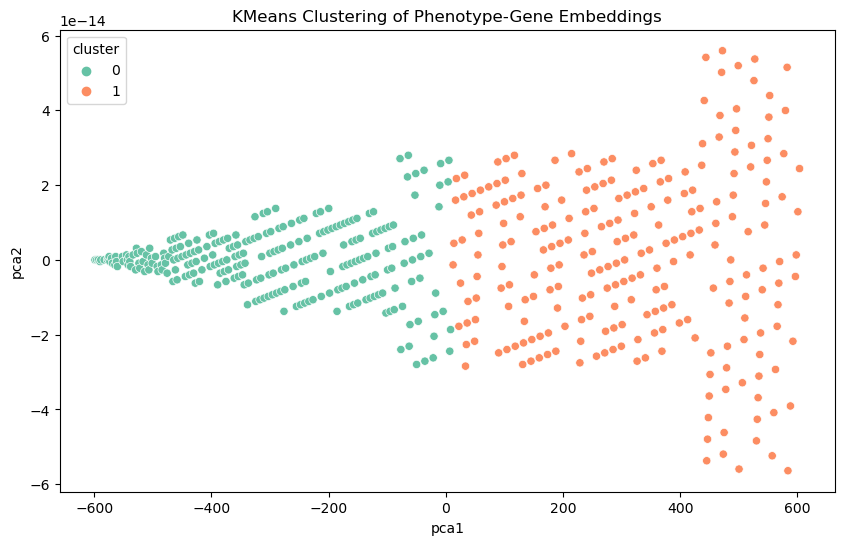

In [17]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=seed)
merged_data['cluster'] = kmeans.fit_predict(merged_data[['pca1', 'pca2']])

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title('KMeans Clustering of Phenotype-Gene Embeddings')
plt.show()


# Conclusion and insights

Based on the results from the PCA and clustering, analyze whether there is a visible separation between causal and non-causal genes.

In [18]:
# Analyzing cluster overlap with causal labels
cluster_vs_label = pd.crosstab(merged_data['cluster'], merged_data['label'])
print(cluster_vs_label)

label    non-causal
cluster            
0               258
1               242


# Export results

In [19]:
# Save the processed data and PCA results
merged_data.to_csv('final_data.csv', index=False)